# Prepare data for SOMMET

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import geopandas as gpd
import zipfile
import rasterio
from matplotlib.markers import MarkerStyle
from string import ascii_lowercase
import json
import matplotlib.patheffects as pe
import urllib.request
import shutil

In [2]:
warnings.simplefilter('once', RuntimeWarning)

In [3]:
# Display figures inline
%matplotlib inline

# Retrieve and inspect metadata

In [4]:
attrs = pd.read_csv("marquardt_table_extended.csv", sep=",")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
#attrs = attrs[attrs.hasdata]
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,calfactjfc1,sensitivity,biomass,rhob,thetaeq,thetaeq2,thetaeqavg,id
id,,,,,,,,,,,,,,,,,,
1,UP,CRS 2000-B,12.958332,52.466406,True,True,2019-11-21 11:30:00,2019-11-23 09:45:00,1100,3000,1.143399,1.19000,1.746,1.315000,0.027,0.027,0.027,1
2,UP,CRS 1000,12.956236,52.466162,False,True,2019-10-15 11:40:00,2019-10-17 17:15:00,300,1100,0.436303,0.45200,6.538,1.257000,0.029,0.028,0.028,2
4,UP,Lab-C,12.957875,52.467125,True,True,2020-01-10 12:00:00,2020-01-12 08:30:00,4000,12000,4.554603,4.54400,4.640,1.380000,0.028,0.028,0.028,4
9,UFZ,Styx Neutronica,12.957530,52.465357,False,True,2019-12-11 09:10:00,2019-12-12 09:45:00,2500,5000,NaN,2.40200,3.997,1.214000,0.031,0.030,0.030,9
11,UP,Lab-C,12.959215,52.466434,True,False,2019-12-17 14:40:00,2019-12-19 10:38:00,5000,10000,NaN,4.75400,1.378,1.346000,0.027,0.027,0.027,11
12,UFZ,Styx Neutronica,12.958544,52.467575,False,True,2020-01-13 11:56:00,2020-01-16 12:00:00,1500,4000,NaN,1.81800,3.102,1.316000,0.028,0.028,0.028,12
13,UFZ,Styx Neutronica,12.959292,52.465705,False,True,2020-01-09 09:40:00,2020-01-10 10:10:00,500,1800,NaN,2.16500,2.497,1.239000,0.033,0.032,0.032,13
21,GFZ,CRS 2000-B,12.957486,52.465838,True,True,2019-12-05 12:50:00,2019-12-07 08:30:00,1100,3000,1.143399,1.13200,2.781,1.366000,0.035,0.034,0.035,21
22,GFZ,CRS 2000-B,12.958571,52.465570,True,True,2019-11-07 14:10:00,2019-11-09 14:30:00,1100,3000,1.168573,1.16100,1.477,1.296000,0.034,0.033,0.034,22


### Project geographic coordinates to UTM 32 N

In [5]:
wgs84 = wradlib.georef.epsg_to_osr(4326)
utm = wradlib.georef.epsg_to_osr(25833)

In [6]:
attrs["x"], attrs["y"] = wradlib.georef.reproject(attrs.lon, attrs.lat, projection_target=utm)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):


# Meteo data

In [7]:
startmeteo = "2022-09-01 00:00:00"

In [8]:
def retrieve_dwd_data(f_http, f_zip, f_trg):
    urllib.request.urlretrieve(f_http, f_zip)
    with zipfile.ZipFile(f_zip) as z:
        for item in z.filelist:
            if "produkt_" in item.orig_filename:
                with z.open(item) as zf, open(f_trg, 'wb') as f:
                    shutil.copyfileobj(zf, f)

In [9]:
# temperature recent
recent_temp_http = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_03987_akt.zip"
recent_temp_zip = "data/dwd/tmp.zip"
recent_temp_file = "data/dwd/temp_recent.txt"
retrieve_dwd_data(recent_temp_http, recent_temp_zip, recent_temp_file)
# precipitation recent
recent_prec_http = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_03987_akt.zip"
recent_prec_zip = "data/dwd/tmp.zip"
recent_prec_file = "data/dwd/prec_recent.txt"
retrieve_dwd_data(recent_prec_http, recent_prec_zip, recent_prec_file)
# pressure recent
recent_press_http = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_03987_akt.zip"
recent_press_zip = "data/dwd/tmp.zip"
recent_press_file = "data/dwd/press_recent.txt"
retrieve_dwd_data(recent_press_http, recent_press_zip, recent_press_file)

In [10]:
# recent
#f_prec = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_RR_03987_akt.txt"
#f_prec = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_RR_03987_akt/produkt_rr_stunde_20211201_20230603_03987.txt"
prec = pd.read_csv(recent_prec_file, sep=";", na_values=-999)
prec.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec.datetime = pd.to_datetime(prec.datetime, format="%Y%m%d%H")
prec = prec.set_index("datetime")
# historical
#f_prec_hist = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_RR_03987_19950901_20201231_hist/produkt_rr_stunde_19950901_20201231_03987.txt"
f_prec_hist = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_RR_03987_19950901_20221231_hist/produkt_rr_stunde_19950901_20221231_03987.txt"
prec_hist = pd.read_csv(f_prec_hist, sep=";", na_values=-999)
prec_hist.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec_hist.datetime = pd.to_datetime(prec_hist.datetime, format="%Y%m%d%H")
prec_hist = prec_hist.set_index("datetime")
# merge
prec = prec.append(prec_hist)
prec = prec.sort_index()
dupl = prec.index.duplicated()
prec = prec.loc[~dupl]
prec_dwd_all = prec.copy()
prec = prec.loc[startmeteo:]

/tmp/ipykernel_11104/4118238291.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prec = prec.append(prec_hist)


In [11]:
# recent
#f_press = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_P0_03987_akt.txt"
#f_press = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_P0_03987_akt/produkt_p0_stunde_20211201_20230603_03987.txt"
press = pd.read_csv(recent_press_file, sep=";", na_values=-999)
press.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press.datetime = pd.to_datetime(press.datetime, format="%Y%m%d%H")
press = press.set_index("datetime")
# historical
#f_press_hist = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_P0_03987_19750701_20201231_hist/produkt_p0_stunde_19750701_20201231_03987.txt"
f_press_hist = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_P0_03987_19750701_20221231_hist/produkt_p0_stunde_19750701_20221231_03987.txt"
press_hist = pd.read_csv(f_press_hist, sep=";", na_values=-999)
press_hist.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press_hist.datetime = pd.to_datetime(press_hist.datetime, format="%Y%m%d%H")
press_hist = press_hist.set_index("datetime")
# merge
press = press.append(press_hist)
press = press.sort_index()
dupl = press.index.duplicated()
press = press.loc[~dupl]
press_dwd_all = press.copy()
press = press.loc[startmeteo:]

/tmp/ipykernel_11104/883778828.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  press = press.append(press_hist)


In [12]:
# recent
#f_temphum = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_TU_03987_akt.txt"
#f_temphum = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_TU_03987_akt/produkt_tu_stunde_20211201_20230603_03987.txt"
temphum = pd.read_csv(recent_temp_file, sep=";", na_values=-999)
temphum.columns = ["station_id", "datetime", "quality", "temp2m", "relhum2m", "eor"]
temphum.datetime = pd.to_datetime(temphum.datetime, format="%Y%m%d%H")
temphum = temphum.set_index("datetime")
# historical
#f_temphum_hist = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_TU_03987_18930101_20201231_hist/produkt_tu_stunde_18930101_20201231_03987.txt"
f_temphum_hist = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_TU_03987_18930101_20221231_hist/produkt_tu_stunde_18930101_20221231_03987.txt"
temphum_hist = pd.read_csv(f_temphum_hist, sep=";", na_values=-999)
temphum_hist.columns = ["station_id", "datetime", "quality", "temp2m", "relhum2m", "eor"]
temphum_hist.datetime = pd.to_datetime(temphum_hist.datetime, format="%Y%m%d%H")
temphum_hist = temphum_hist.set_index("datetime")
# merge
temphum = temphum.append(temphum_hist)
temphum = temphum.sort_index()
dupl = temphum.index.duplicated()
temphum = temphum.loc[~dupl]
temphum["abshum2m"] = cs.conv.absolute_humidity(temphum.temp2m, temphum.relhum2m)
temphum_dwd_all = temphum.copy()
temphum = temphum.loc[startmeteo:]

/tmp/ipykernel_11104/3846553771.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temphum = temphum.append(temphum_hist)


# Read raw data

#### Read sensor data

In [13]:
#fpath = "/media/x/cosmicsense/data/marquardt/crns/"
fpath = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/merged/"
crns = {}
for id in attrs.index:
    #print(id)
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d_CRNS.txt" % id), sep="\t", na_values="na")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id in [4,11,33]:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
#     elif id in [26,27]:
#         df["cph1"] = df.counts_labc / cs.conv.s_to_h(df.nsecs_labc)
#        df["cph1"] = (df.counts_labc + df.counts_crs1000) / cs.conv.s_to_h(df.nsecs_labc)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
    print(id, end=": ")
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2022-09-30 23:12:00 to 2023-06-28 12:56:00
4: 2022-09-30 22:32:00 to 2023-06-28 08:52:00
11: 2022-11-15 11:38:29 to 2023-06-28 10:38:00
21: 2022-09-30 18:50:00 to 2023-06-28 11:12:00
22: 2022-09-30 18:55:00 to 2023-06-28 12:42:00
26: 2022-09-30 19:10:00 to 2023-05-25 08:55:00
27: 2022-10-11 09:48:37 to 2023-05-26 08:00:01
32: 2022-04-25 12:00:00 to 2023-06-28 13:00:00
33: 2022-09-29 08:49:00 to 2023-06-28 09:28:00
34: 2023-03-14 08:42:47 to 2023-06-28 09:18:00
35: 2022-11-16 12:55:04 to 2023-06-28 08:47:00


In [14]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)
min_dtime = dt.datetime(2022,11,1)

2022-04-25 12:00:00 - 2023-06-28 13:00:00


## Filter spurious signals

Some probes are affected by spurious count rates. In order to keep useful parts of the signal, a pragmatic/heuristic filtering approach is applied which could be refined later:

1. Remove entirely unrealisticly count rates for specific probes (`mincph`, `maxcph`)
2. Remove count rates from spuriously short count intervals (`mininterv`)
3. After that, there are still spurious count rates.In order to detect these, we compute the maximum count rates over periods of six hours, and then apply a 24-hour-median filter to these 6-hour-maxima. That way, we try to truncate spurios peaks. In order to prevent too aggressive filtering, we add a `buffer` of the median count rates over a period of 24 hours.
4. We then interpolate this upper limit filter to the original timestamp values and use it to remove high values.
5. We remove unrealisticly low count rates (`mincph`), and than apply the same approach (points 3-4) to eliminate spuriously small values.  

In [15]:
buffer = 0.15
mininterv = 600

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    x[x > attrs.loc[key, "maxcph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan
    try:
        x[crns[key].nsecs1 < mininterv] = np.nan
    except AttributeError:
        x[crns[key].nsecs_labc < mininterv] = np.nan
#     if key==27:
#         # Period of erratic behaviour due to battery failure
#         x["2019-11-16 18:00:00":"2019-12-02 02:00:00"] = np.nan
    median24 = x.resample("24H").median()
    #median24.index = median24.index + dt.timedelta(seconds=3600*12)
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - buffer * median24)
    # Resample filter to original time stamps
    #crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index+dt.timedelta(seconds=3600*12), maxfilter)
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
    crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

<AxesSubplot:xlabel='datetime'>

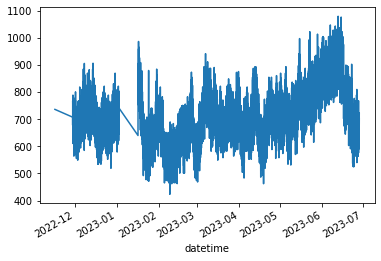

In [16]:
crns[35].cph1.plot()

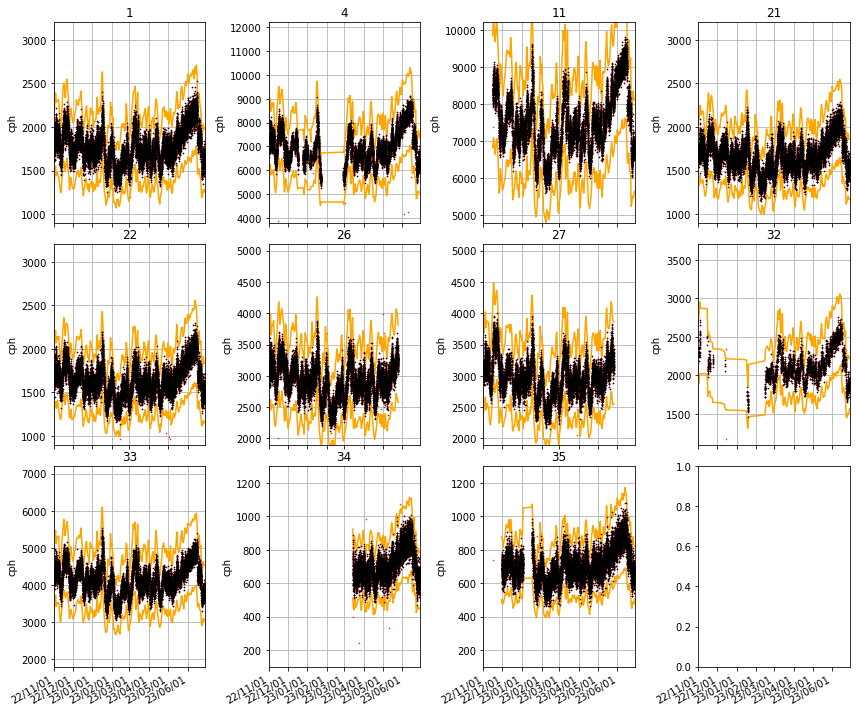

In [17]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12,10), sharex=True)
ax = ax.ravel()

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    ax[i].set_ylim(attrs.loc[key,"mincph"]-200, attrs.loc[key, "maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.2)

## Finally applying the sensitivity correction factors

In [18]:
for id in crns.keys():
    crns[id]["cph1cal"] = crns[id]["cph1_filtered"] / attrs.loc[id, "sensitivity"]

/tmp/ipykernel_11104/2606306502.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['sdiAdr'], dtype='object')
  tmp = crns[key].rolling("48H", min_periods=2*48-10).mean()
/tmp/ipykernel_11104/2606306502.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['sdiAdr'], dtype='object')
  tmp = crns[key].rolling("48H", min_periods=2*48-10).mean()
/tmp/ipykernel_11104/2606306502.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['sdiAdr'], dtype='object')
  tmp = crns[key].rolling("48H", min_periods=2*

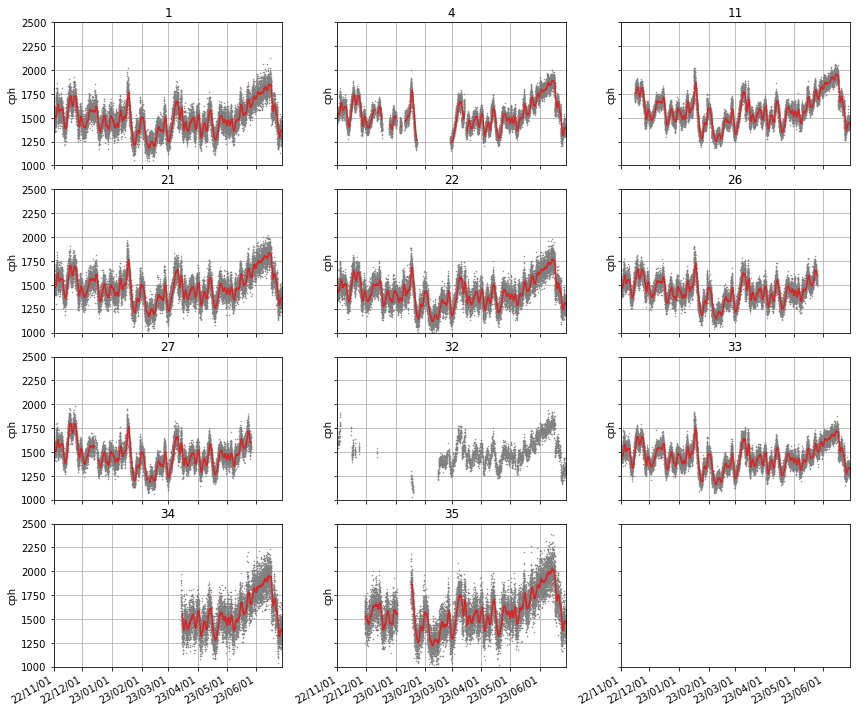

In [19]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,10), sharex=True, sharey=True)
ax = ax.ravel()

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    tmp = crns[key].rolling("48H", min_periods=2*48-10).mean()
    ax[i].plot(crns[key].index, crns[key].cph1cal, linestyle="None", marker=".", ms=1, color="grey")
    ax[i].plot(tmp.index, tmp.cph1cal, color="tab:red")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))
    ax[i].grid()
    ax[i].set_ylim(1000, 2500)
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.2)

## Resample to uniform 20 minute interval

In [20]:
dtrange = pd.date_range(min_dtime, max_dtime, freq="20T")
crns20 = pd.DataFrame({}, index=dtrange)

for i, key in enumerate(crns.keys()):
    crns20[key] = crns[key].cph1cal.resample('20T').nearest(limit=1).reindex(dtrange)

In [21]:
crns20

,1,4,11,21,22,26,27,32,33,34,35
2022-11-01 00:00:00,1535.294118,1558.098592,NaN,1380.742049,1449.612403,1410.589215,1568.181818,NaN,1431.615375,NaN,NaN
2022-11-01 00:20:00,1486.287970,1499.552176,NaN,1443.387996,1407.334377,1488.004710,1492.588933,NaN,1453.862038,NaN,NaN
2022-11-01 00:40:00,1554.445751,1550.090014,NaN,1518.551237,1502.464171,1532.352941,1482.213439,NaN,1412.966289,NaN,NaN
2022-11-01 01:00:00,1595.798319,1548.855634,NaN,1468.197880,1444.444444,1483.823529,1473.320158,NaN,1423.409499,NaN,NaN
2022-11-01 01:20:00,1404.201681,1557.438380,NaN,1529.151943,1341.085271,1477.941176,1505.928854,NaN,1492.334684,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-28 11:40:00,1368.907563,NaN,NaN,NaN,1299.741602,NaN,NaN,1311.528802,NaN,NaN,NaN
2023-06-28 12:00:00,1343.697479,NaN,NaN,NaN,1284.237726,NaN,NaN,1311.528802,NaN,NaN,NaN
2023-06-28 12:20:00,1315.966387,NaN,NaN,NaN,1284.237726,NaN,NaN,1311.528802,NaN,NaN,NaN
2023-06-28 12:40:00,1290.756303,NaN,NaN,NaN,1281.653747,NaN,NaN,1348.693891,NaN,NaN,NaN


## Correcting for incoming neutron flux

#### NMBD station data

`nmdb.txt` contains reference (background) neutron count rates from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL2`, `JUNG`, `JUNG1`, and `DRBS` (Dourbes, Belgium). 

In [22]:
# # NMDB data
# nmdb = pd.read_csv("/media/x/cosmicsense/data/marquardt/nmdb/nmdb.txt", sep=";", comment="#", na_values="   null")
# nmdb.datetime = pd.to_datetime(nmdb.datetime)
# nmdb = nmdb.set_index("datetime")

# nmdb.JUNG[nmdb.JUNG>200] = np.nan

In [23]:
now = dt.datetime.now()

nmdbhttp = "http://nest.nmdb.eu/draw_graph.php?formchk=1&stations[]=JUNG&stations[]=JUNG1&stations[]=KIEL2&tabchoice=revori&dtype=corr_for_efficiency&tresolution=60&force=1&yunits=0&date_choice=bydate&start_day=1&start_month=6&start_year=2019&start_hour=0&start_min=0&end_day=%d&end_month=%d&end_year=%d&end_hour=%d&end_min=%d&output=ascii" % (now.day, now.month, now.year, now.hour, 0)
urllib.request.urlretrieve(nmdbhttp, "nmdbtmp.txt")

with open("nmdbtmp.txt", "r") as f:
    lines = f.readlines()

with open("nmdbtmp2.txt", "w") as f:
    startdata = False
    for line in lines:
        if "QUERY RESULTS SUMMARY" in line:
            startdata = True
            continue
        if "Total Execution Time" in line:
            break
        if startdata:
            if not line[0]=="#":
                f.write(line)
nmdb = pd.read_csv("nmdbtmp2.txt", sep=";", skiprows=1, na_values="   null")
nmdb.columns = ["datetime", "JUNG", "JUNG1", "KIEL2"]
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

nmdb.JUNG[nmdb.JUNG>200] = np.nan
        

In [24]:
nmdb

,JUNG,JUNG1,KIEL2
datetime,,,
2019-06-01 01:00:00,165.716,367.513,182.927
2019-06-01 02:00:00,165.825,367.587,186.128
2019-06-01 03:00:00,165.466,367.617,187.276
2019-06-01 04:00:00,165.852,367.544,187.677
2019-06-01 05:00:00,166.024,368.018,187.543
...,...,...,...
2023-06-28 09:00:00,151.590,366.631,165.043
2023-06-28 10:00:00,151.993,366.320,164.677
2023-06-28 11:00:00,151.661,367.565,167.195


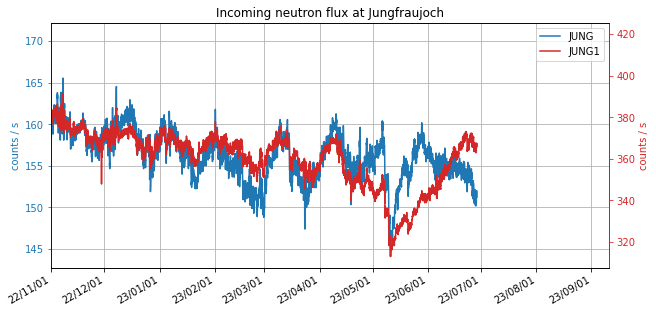

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 5), sharex=True)
jungcol = "tab:blue"
jung = plt.plot(nmdb.index, nmdb.JUNG, color=jungcol)
plt.ylabel("counts / s", color=jungcol)
ax1.spines['left'].set_color(jungcol)
ax1.tick_params(axis='y', colors=jungcol)
ax1.grid()

ax2 = ax1.twinx()
jung1col = "tab:red"
jung1 = plt.plot(nmdb.index, nmdb.JUNG1, color="tab:red")
plt.ylabel("counts / s", color=jung1col)
ax2.spines['right'].set_color(jung1col)
ax2.tick_params(axis='y', colors=jung1col)

leg = plt.legend(jung+jung1, ["JUNG", "JUNG1"])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Incoming neutron flux at Jungfraujoch")
#plt.xlim(dt.datetime(2020,7,1), dt.datetime(2020,7,5))
#plt.ylim(160,170)

#plt.xlim(dt.datetime(2020,8,1),dt.datetime(2020,8,11))

fig.autofmt_xdate() 

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch (JUNG).

In [26]:
fi = (nmdb.JUNG / nmdb.JUNG.mean())
fi.name="fi"
fi = fi.resample("1H").mean().resample("20T").ffill().reindex(dtrange)
fi2 = (nmdb.JUNG1 / nmdb.JUNG1.mean())
fi2.name="fi2"
fi2 = fi2.resample("1H").mean().resample("20T").ffill().reindex(dtrange)

## Correcting for barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

For $p_0$, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ or the site average pressure, and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [27]:
p_0 = press.p0.mean()
L = 131.6 # g/cm2
fp = cs.core.corrfact_baro(press.p0, p_0, L)
#fp = fp.rolling("48H").median()
#fp.index = fp.index - dt. timedelta(seconds=24*3600)
fp = fp.resample("20T").ffill().reindex(dtrange)
fp.name="fp"

# p_0_atb = meteoatb.press.mean()
# fp_atb = cs.core.corrfact_baro(meteoatb.press, p_0_atb, L)
# fp_atb = fp_atb.resample("20T").ffill().reindex(dtrange)
# fp_atb.name="fp_atb"

## Correcting for atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

In [28]:
fwv = cs.core.corrfact_vapor_rosolem(temphum.abshum2m)
fwv.name = "fwv"
fwv = fwv.resample("20T").ffill().reindex(dtrange)

# fwv_atb = cs.core.corrfact_vapor_rosolem(meteoatb.abshum)
# fwv_atb.name = "fwv_atb"
# fwv_atb = fwv_atb.resample("20T").ffill().reindex(dtrange)

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

In [29]:
crns20c = crns20.copy()
for id in crns20c.keys():
    crns20c[id] = crns20c[id] * fwv / (fi * fp)

(19417.0, 19509.0)

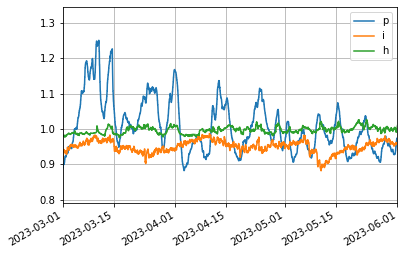

In [30]:
fig, ax = plt.subplots(1,1)
plt.plot(fp.index, fp, label="p")
plt.plot(fi.index, fi, label="i")
plt.plot(fwv.index, fwv, label="h")
plt.grid()
plt.legend()
fig.autofmt_xdate()
plt.xlim(dt.datetime(2023,3,1), dt.datetime(2023,6,1))

# Correct for biomass

In [31]:
crns20c_vegc = crns20c.copy()
for id in crns20c.keys():
    #crns20c_vegc[id] = crns20c_vegc[id] / (1 - attrs.loc[id, "biomass"] * attrs.loc[id, "forestfrac"] * 0.9 / 100.)
    crns20c_vegc[id] = crns20c_vegc[id] / (1 - attrs.loc[id, "biomass"] * 0.9 / 100.)

# SWC time series

In [32]:
avgn0 = 2407.7 # cph

In [33]:
#h24 = crns20c_vegc.rolling("24H", min_periods=int(0.8*3*24)).mean()
h24 = crns20c_vegc.rolling("1D").mean()#, min_periods=int(0.8*3*6)).mean()
crnstheta = h24.apply(copy.deepcopy)
for id in crnstheta.keys():#[attrs.hasdata]:
    crnstheta[id] = cs.core.n_to_theta_desilets(h24[id].copy(), n0=avgn0, rhob=attrs.loc[id,"rhob"]*1000) \
                    - attrs.thetaeqavg[id]
#crnstheta[9] = np.nan
#crnstheta[12] = np.nan
#crnstheta[13] = np.nan

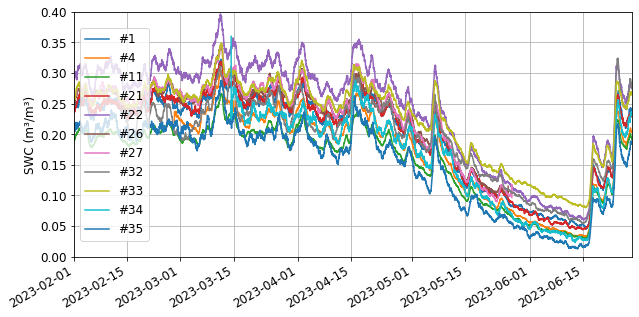

In [36]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in [1,4,11,21,22,26,27,32,33,34,35]:
#for i in [11,26,32,33,34,35]:
    plt.plot(crnstheta.index, crnstheta[i], label="#%d" % i)
plt.legend(loc="center left")
plt.grid()
plt.xlim(dt.datetime(2023,2,1), dt.datetime(2023,6,28))
plt.ylabel("SWC (m³/m³)")
plt.ylim(0,0.4)
fig.autofmt_xdate()
plt.savefig("sommet.png", dpi=300, facecolor="white")

In [35]:
crnstheta.to_csv("sommet.csv", sep=";", index=True, index_label="datetime", float_format="%.3f", na_rep="na")